In [ ]:
import torch
import cv2

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tqdm import tqdm
import sys

In [ ]:
CSV_FILE = '/content/drive/MyDrive/Winstars_Technology/data/train_ship_segmentations_v2.csv'
DATA_DIR = '/content/drive/MyDrive/Winstars_Technology/data/'
sys.path.append(DATA_DIR)
DEVICE = 'cuda'

EPOCHS = 25
LR = 0.001
IMAGE_SIZE = 320
BATCH_SIZE = 16

ENCODER = 'timm-efficientnet-b0'
WEIGHTS = 'imagenet'

In [ ]:
import os
uploaded_samples = os.listdir(DATA_DIR+'train_v2')

In [ ]:
df = pd.read_csv(CSV_FILE)
df = df[df.ImageId.isin(uploaded_samples)]
df.head()

,ImageId,EncodedPixels
0,00003e153.jpg,NaN
1,0001124c7.jpg,NaN
2,000155de5.jpg,264661 17 265429 33 266197 33 266965 33 267733...
3,000194a2d.jpg,360486 1 361252 4 362019 5 362785 8 363552 10 ...
4,000194a2d.jpg,51834 9 52602 9 53370 9 54138 9 54906 9 55674 ...


In [ ]:
def get_mask(encoded_str, image):
  '''returns a 2D array mask for the image'''
  h, w, _ = image.shape
  mask = np.zeros(h*w, dtype=int)

  if pd.isna(encoded_str):
    return mask.reshape(h, w)
  mask_encoded_arr = np.array(encoded_str.split(' '), dtype=int)
  start_pix = mask_encoded_arr[::2]
  count_pix = mask_encoded_arr[1::2]
  mask_idx = np.concatenate([np.arange(start_pix[i]-1, start_pix[i]+count_pix[i]-1) for i in range(len(count_pix))])

  mask[mask_idx] = 1
  return mask.reshape(w, h).T

In [ ]:
df_ship = df[~df.EncodedPixels.isna()]
df_no_ship = df[df.EncodedPixels.isna()]

In [ ]:
df_ship_comb = df_ship.copy()
df_ship_comb.EncodedPixels = df_ship.EncodedPixels + ' '
df_ship_comb = df_ship_comb.pivot_table(values='EncodedPixels', index = 'ImageId', aggfunc= 'sum').reset_index()
df_ship_comb['EncodedPixels'] = df_ship_comb['EncodedPixels'].apply(lambda x: x.strip())

In [ ]:
df_train_all = pd.concat((df_no_ship, df_ship_comb)).sample(frac=1, random_state=21)
df_train_all.head()

,ImageId,EncodedPixels
2393,d3426de05.jpg,378010 5 378769 14 379528 23 380287 32 381046 ...
1923,022444d9e.jpg,NaN
959,409bd8d45.jpg,24312 1 25079 4 25847 5 26614 8 27381 10 28149...
108603,77a08ff10.jpg,NaN
217673,f07f62d1c.jpg,NaN


In [ ]:
print(f'{len(df_train_all)-df_train_all.EncodedPixels.isna().sum()} images contain ships')
print(f'{df_train_all.EncodedPixels.isna().sum()} images do not contain any ships')

2840 images contain ships
9948 images do not contain any ships


In [ ]:
def plot_ships(list_of_images, list_of_masks):
  '''plots images and their masks'''
  plt.figure(figsize=(12, 6))
  for i in range(4):

    row = df.iloc[i]

    image = list_of_images[i]
    mask = list_of_masks[i]

    plt.subplot(2, 4,i*2+1)
    plt.imshow(image)
    plt.xticks([])
    plt.yticks([])

    plt.subplot(2, 4,i*2+2)
    plt.imshow(mask, cmap = 'gray')
    plt.xticks([])
    plt.yticks([])
    if mask.sum()==0:
      plt.title('no ships')
    else:
      plt.title('ship segmentation')
  plt.tight_layout()

In [ ]:
def plot_orig_data(df, i_start):
  list_of_images = []
  list_of_masks = []
  for i in range(4):
    row = df.iloc[i+i_start]

    image_path = row.ImageId
    image = cv2.imread(DATA_DIR+'train_v2/'+image_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    list_of_images.append(image)

    mask_encoded = row.EncodedPixels
    mask = get_mask(mask_encoded, image)
    list_of_masks.append(mask)
  plot_ships(list_of_images, list_of_masks)

In [ ]:
def plot_set_data(set, i_start):
  list_of_images = []
  list_of_masks = []
  for idx in range(4):
    image, mask = set[idx+i_start]
    image = np.transpose(image.numpy(), (1, 2, 0)).astype(np.float32)
    mask = np.transpose(mask.numpy(), (1, 2, 0)).astype(np.float32).squeeze()
    list_of_images.append(image)
    list_of_masks.append(mask)

  plot_ships(list_of_images, list_of_masks)

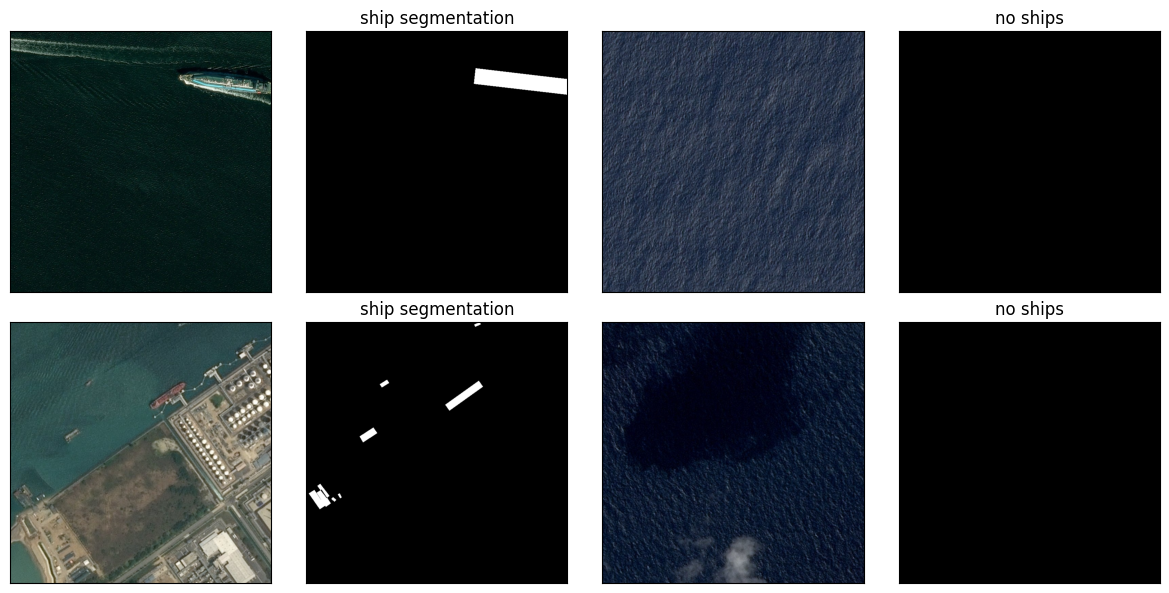

In [ ]:
plot_orig_data(df_train_all, 0)

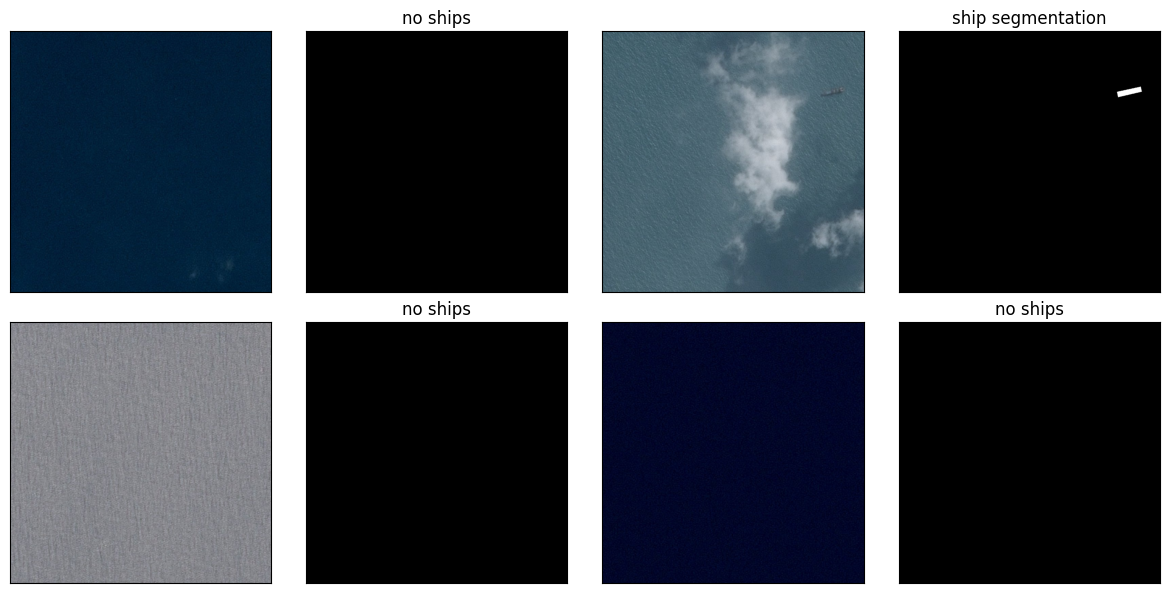

In [ ]:
plot_orig_data(df_train_all, 4)

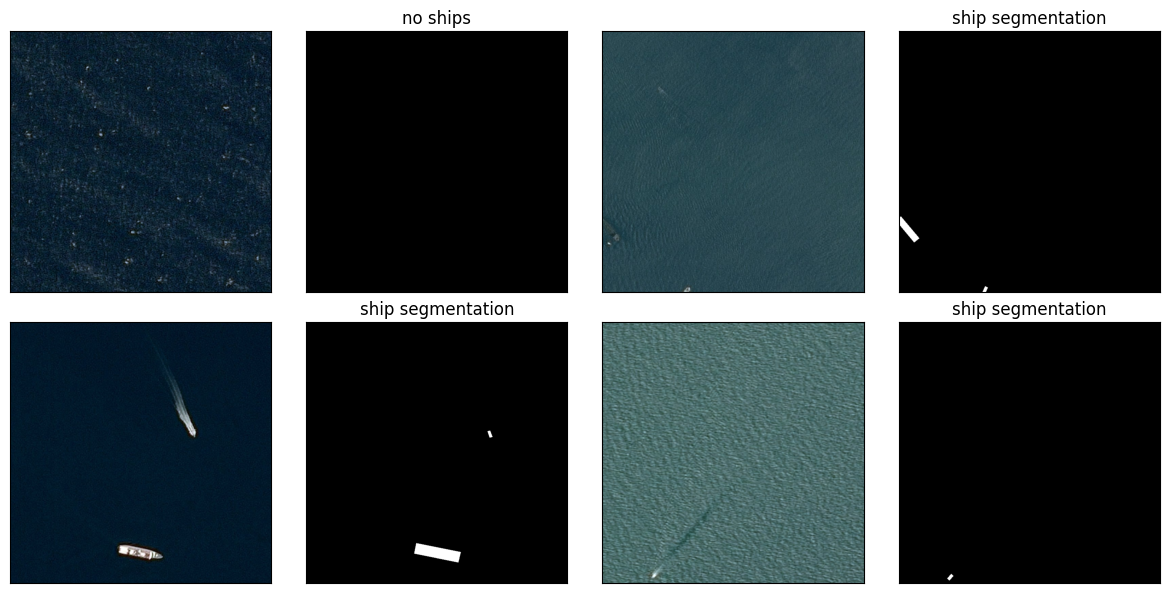

In [ ]:
plot_orig_data(df_train_all, 8)

In [ ]:
from torchvision.io import read_image
for image in df_train_all['ImageId'][:30]:
  print(read_image(DATA_DIR+'train_v2/'+image).shape)

torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])
torch.Size([3, 768, 768])


In [ ]:
LR_list = []
LR = 0.001
for epoch in range(100):
    LR = LR * 1 / (1 + LR * epoch)
    LR_list.append(LR)

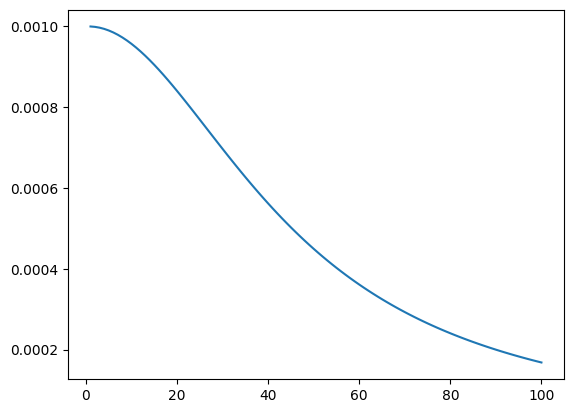

In [ ]:
import matplotlib.pyplot as plt
plt.plot(range(1, 101), LR_list)